In [1]:
# Imports
from random import choice
import gym
import pandas as pd
import pygame
import numpy as np
import tensorflow as tf
from gym import spaces
from copy import deepcopy
import pygame.font
from torch import cat
pygame.font.init()
pygame.init()
print("Num GPUs Available: ", tf.config.list_physical_devices('GPU'))

2023-07-04 23:04:15.732296: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-04 23:04:15.733914: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-04 23:04:15.761014: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-04 23:04:15.761508: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-04 23:04:16.149733: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

Num GPUs Available:  []


In [2]:
validwords = []
with open('resources/wordlist.txt') as wordlist:
    for line in wordlist:
        # clean the line
        text = line.replace('\n', '')
        validwords.append(text.lower().strip())
print(len(validwords))



2315


In [3]:
class Wordle:
    def __init__(self, word, rows=6, letters=5):
        self.g_count = 0
        self.word = word
        self.w_hash_table = {}
        if word is not None:
            for x, l in enumerate(word):
                if l in self.w_hash_table:
                    self.w_hash_table[l]['count'] += 1
                    self.w_hash_table[l]['pos'].append(x)
                else:
                    self.w_hash_table[l] = {'count':1, 'pos':[x]}
        self.rows = rows
        self.letters = letters
        self.board = [['' for _ in range(letters)] for _ in range(rows)]
        self.colours = [['B' for _ in range(letters)] for _ in range(rows)]
        self.alph = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

    def is_end(self):
        if self.board[-1] != ['' for _ in range(self.letters)]:
            return True
        else:
            r = self.game_result()
            if r[0] == True:
                return True
            else:
                return False

    def game_result(self):
        win = (False, 100)
        for i, r in enumerate(self.board):
            if self.word == ''.join(r):
                win = (True, i)
                break
        return win

    def update_board(self, u_inp):
        w_hash_table = deepcopy(self.w_hash_table)
        i_hash_table = {}
        for x, l in enumerate(str(u_inp).upper()):
            self.board[self.g_count][x] = l
            if l in i_hash_table:
                i_hash_table[l].append(x)
            else:
                i_hash_table[l] = [x]
        colours = {'G':[],'B':[],'Y':[]}
        for l in i_hash_table:
            if l in w_hash_table:
                g_hold = []
                for p in i_hash_table[l]:
                    if p in w_hash_table[l]['pos']:
                        g_hold.append(p)
                for p in g_hold:
                    i_hash_table[l].remove(p)
                colours['G'] += g_hold
                if len(g_hold) < w_hash_table[l]['count']:
                    y_hold = []
                    for p in i_hash_table[l]:
                        y_hold.append(p)
                        if len(y_hold) == w_hash_table[l]['count']:
                            break
                    for p in y_hold:
                        i_hash_table[l].remove(p)
                    colours['Y'] += y_hold
                for p in i_hash_table[l]:
                    colours['B'].append(p)
            else:
                colours['B'] += i_hash_table[l]
                i_hash_table[l] = []
        for c in colours:
            for p in colours[c]:
                self.colours[self.g_count][p] = c
        self.g_count += 1

    def valid_guess(self, u_inp):
        if len(u_inp) == 5 and False not in [False for s in str(u_inp).upper() if s not in self.alph]:
            return True
        else:
            return False

class WordleEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    SCREEN_DIM = 500
    GREEN = "#6aaa64"
    YELLOW = "#c9b458"
    GREY = "#787c7e"
    OUTLINE = "#d3d6da"
    FILLED_OUTLINE = "#878a8c"

    def __init__(self, answers, logging=False):
        self.logging = logging
        self.answers = pd.DataFrame(answers)
        self.answers.columns = ['words']
        self.screen = None
        self.isopen = False
        self.GUESSES = 6
        self.LETTERS = 5
        self.WORD = self.answers['words'].sample(n=1).tolist()[0].upper()
        self.WORDLE = Wordle(self.WORD, self.GUESSES, self.LETTERS)
        self.alpha = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
        self.colors = ['B', 'Y', 'G']
        self.is_game_over = False
        self.guessed_words = []
        self.blank_letters = []
        
        #self.blanks = [0 for i in range(27)]
        #self.yellow = [0 for i in range(27)]
        #self.green = [0 for i in range(27)]
        
        # our action space is the total amount of possible words to guess
        self.action_space = spaces.Discrete(len(answers))
        #our observation space is the current wordle board in form of (letter, color) with 5x6 (5 letters, 6 guesses)
        #modified to work with gym/baselines
        #same thing basically, only 0-26 is '' to z and 27-29 is B, Y, G
        # first 6 rows are guesses and last 6 rows are colors
        # changed shape to be 3 dimensions so that we can apply conv2d layers to it
        # at some point we should try to normalize the obs space
        # since right now its on a 0-29 scale instead of a 0-1.
        self.observation_space = spaces.Box(low=0, high=29, shape=(2,6,5), dtype='int32')
        self.current_episode = -1
        self.episode_memory: list[any] = []

    def step(self, action):
        if self.is_game_over:
            return RuntimeError('Episode is already done')
        guess = self._take_action(action)
        reward = self._get_reward(guess)
        self.guessed_words.append(guess.upper())
        observation = self._get_observation()
        res = self.WORDLE.colours[self.WORDLE.g_count-1]
        self.blank_letters.extend([ l for i,l in enumerate(guess) if res[i] == 'B' and l not in self.blank_letters])
        return observation, reward, self.is_game_over, {}

    def reset(self):
        self.current_episode = -1
        self.episode_memory.append([])
        self.is_game_over = False
        self.WORD = self.answers['words'].sample(n=1).tolist()[0].upper()
        self.WORDLE = Wordle(self.WORD, self.GUESSES, self.LETTERS)
        self.guessed_words = []
        self.blank_letters = []
        if self.logging:
            #print(self.WORDLE.word)
            pass
        self.close()
        return self._get_observation()

    def render(self, mode='human'):
        pygame.init()
        pygame.display.init()
        self.screen = pygame.display.set_mode((self.SCREEN_DIM, self.SCREEN_DIM))
        font = pygame.font.Font('freesansbold.ttf', 30)
        for col in range(0, 5):
            for row in range(0, 6):
                pygame.draw.rect(self.screen, self.OUTLINE, [col * 100 + 12, row * 100 + 12, 75, 75], 3, 5)
                color = self.GREEN if self.WORDLE.colours[row][col] == 'G' else self.YELLOW if self.WORDLE.colours[row][col] == 'Y' else self.GREY
                piece_text = font.render(self.WORDLE.board[row][col], True, color)
                self.screen.blit(piece_text, (col * 100 + 30, row * 100 + 25))
        #pygame.draw.rect(screen, self.GREEN, [5, turn * 100 + 5, WIDTH - 10, 90], 3, 5)
        if mode == "human":
            pygame.event.pump()
            pygame.display.flip()             
    def close(self):
        if self.screen is not None:
            pygame.display.quit()
            pygame.quit()
            self.isopen = False

    def _take_action(self, action):
        # turn action into guess
        guess = self.answers['words'][action].upper()
        self.episode_memory[self.current_episode].append(guess)
        if self.logging:
            print(guess)
            pass
        self.WORDLE.update_board(guess)
        res = self.WORDLE.colours[self.WORDLE.g_count-1]
        self.is_game_over = self.WORDLE.word == guess.upper() or self.WORDLE.g_count == self.GUESSES
        
        if self.is_game_over and self.logging:
            print(f'Guessed in : {len(self.guessed_words)} \nWords: ', end='')
            print(*self.guessed_words, sep=",")
            print(f'Answer: {self.WORD}')
        if self.WORDLE.word == guess:
            print(f'Guessed {self.WORDLE.word} in {self.WORDLE.g_count} guesses!')
        return guess
    def _get_reward(self, guess):
        result, tries = self.WORDLE.game_result()
        rewards = np.zeros(5)
        #heavily penealize guessing the same word multiple times
        #If a word isn't the right guess, we shouldn't guess it again
        #could do the same thing for letters, as if a letter is blank(grey)
        # then the only reason to use a word with a letter in it
        # is to check other letter posistions
        #so it shouldn't be a heavy penalty but it should be a penalty
        checked_guess = []
        for g, c in zip(guess, self.WORD):
            if g == c:
                checked_guess.append('G')
            elif g in c:
                checked_guess.append('Y')
            else:
                checked_guess.append('B')
        for i,c in enumerate(checked_guess):
            if c == self.colors[2]:
                rewards[i] = 10
            elif c == self.colors[1]:
                rewards[i] = 3
            elif c == self.colors[0]:
                rewards[i] = 1
        #check guesses up to and including our current guess

        reward = np.sum(rewards)
        '''
        for g in range(self.WORDLE.g_count):
            word = self.WORDLE.board[g]
            current = ''.join(word)
            if guess in self.guessed_words:
                print('did this')
                return 0
                print('0')
            for l in word: 
                if l in self.blank_letters:
                    reward -= 0.3'''
        if guess in self.guessed_words:
            return 0
        for l in guess:
            if l in self.blank_letters:
                reward -= 3.5
        if self.logging:
            print(self.WORD)
            print(rewards)
            print(reward)
        return reward

    def _get_observation(self):
        board = np.array(self.WORDLE.board) #2d array of 5x6
        colors = np.array(self.WORDLE.colours) #2d array of 5x6
        results = np.vstack((board, colors)) #stacks boards and colors by rows resulting in a 2d array of 5x12
        convertletterstonum = lambda letter: [self.alpha.index(l) + 1 if l in self.alpha else 0 for l in letter]
        convertcolortonum = lambda color: [self.colors.index(c)+27 for c in color]
        guesses = np.array([convertletterstonum(l) if i <=5 else convertcolortonum(l) for i, l in enumerate(results)])
        guesses = np.array(np.split(guesses, 2, axis=0))
        if self.logging:
            print(np.shape(guesses))
        return guesses
    

In [4]:

env = WordleEnv(validwords, logging=False)
states = env.observation_space.shape
actions = env.action_space.n
print(states)
print(actions)


(2, 6, 5)
2315


In [5]:
from torch import nn
import torch
from tensordict import TensorDict
from torchrl.data import TensorDictReplayBuffer, LazyMemmapStorage
import time, datetime
import matplotlib.pyplot as plt
from pathlib import Path

In [6]:
class WordleNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        c, h, w = input_dim
        bias_layer = nn.Conv2d(in_channels=c, out_channels=32, kernel_size=(h, w), stride=2, dilation=2, padding=7)
        with torch.no_grad():
            bias_layer.bias.fill_(1.)

        self.online = nn.Sequential(
            bias_layer,
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, stride=2, padding=1, dilation=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=2, padding=1, dilation=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(576, 16),
            nn.ReLU(),
            nn.Linear(16, output_dim))
        
        self.target = deepcopy(self.online)
        
        for p in self.target.parameters():
            p.requires_grad = False
    

    
    def forward(self, input, model):
        if model == "online":
            return self.online(input)
        elif model == "target":
            return self.target(input)

In [7]:
class WordleAgent():
    def __init__(self, state_dim, action_dim, save_dir):
        self.memory = TensorDictReplayBuffer(storage=LazyMemmapStorage(10000000, device=torch.device("cpu")))
        self.batch_size = 32
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.save_dir = save_dir

        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        self.net = WordleNet(self.state_dim, self.action_dim).float()
        self.net = self.net.to(device=self.device)

        self.exploration_rate = 1
        self.exploration_rate_decay = 0.99999999999999999999999999999
        self.exploration_rate_min = 0.01
        self.curr_step = 0

        self.save_every = 5e5  # no. of experiences between saving Wordle Net


        #Learning
        self.gamma = 0.9
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.00025)
        self.loss_fn = torch.nn.SmoothL1Loss()

        #Completion
        self.burnin = 1e4  # min. experiences before training
        self.learn_every = 3  # no. of experiences between updates to Q_online
        self.sync_every = 1e4  # no. of experiences between Q_target & Q_online sync

    def act(self, state):
        if np.random.rand() < self.exploration_rate:
            action_idx = np.random.randint(self.action_dim)
        else:
            state = state[0].__array__() if isinstance(state, tuple) else state.__array__()
            state = torch.tensor(state, device=self.device).unsqueeze(0).float()
            action_values = self.net(state, model="online")
            action_idx = torch.argmax(action_values, axis=1).item()
            print(f'Chose word: {action_idx}')
        #decrease exploration rate
        self.exploration_rate *= self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)

        # increment step
        self.curr_step += 1
        return action_idx
    def cache(self, state, next_state, action, reward, done):
        #Stores the environment to self.memory

        def first_if_tuple(x):
            return x[0] if isinstance(x, tuple) else x
        state = first_if_tuple(state).__array__()
        next_state = first_if_tuple(next_state).__array__()

        state = torch.tensor(state)
        next_state = torch.tensor(next_state)
        action = torch.tensor([action])
        reward = torch.tensor([reward])
        done = torch.tensor([done])

        # self.memory.append((state, next_state, action, reward, done,))
        self.memory.add(TensorDict({"state": state, "next_state": next_state, "action": action, "reward": reward, "done": done}, batch_size=[]))
    def recall(self):
        #Retrieve a batch of experiences from self.memory

        batch = self.memory.sample(self.batch_size).to(self.device)
        state, next_state, action, reward, done = (batch.get(key) for key in ("state", "next_state", "action", "reward", "done"))
        return state, next_state, action.squeeze(), reward.squeeze(), done.squeeze()

    def td_estimate(self, state, action):
        current_Q = self.net(state, model="online")[
            np.arange(0, self.batch_size), action
        ]  # Q_online(s,a)
        return current_Q

    @torch.no_grad()
    def td_target(self, reward, next_state, done):
        next_state_Q = self.net(next_state, model="online")
        best_action = torch.argmax(next_state_Q, axis=1)
        next_Q = self.net(next_state, model="target")[
            np.arange(0, self.batch_size), best_action
        ]
        return (reward + (1 - done.float()) * self.gamma * next_Q).float()
    
    def update_Q_online(self, td_estimate, td_target):
        loss = self.loss_fn(td_estimate, td_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def sync_Q_target(self):
        self.net.target.load_state_dict(self.net.online.state_dict())
    
    def learn(self):
        if self.curr_step % self.sync_every == 0:
            self.sync_Q_target()

        if self.curr_step % self.save_every == 0:
            self.save()

        if self.curr_step < self.burnin:
            return None, None

        if self.curr_step % self.learn_every != 0:
            return None, None

        # Sample from memory
        state, next_state, action, reward, done = self.recall()

        state = state.float()
        next_state = next_state.float()

        # Get TD Estimate
        td_est = self.td_estimate(state, action)

        # Get TD Target
        td_tgt = self.td_target(reward, next_state, done)

        # Backpropagate loss through Q_online
        loss = self.update_Q_online(td_est, td_tgt)

        return (td_est.mean().item(), loss)
    
    def save(self):
        save_path = (
            self.save_dir / f"mario_net_{int(self.curr_step // self.save_every)}.chkpt"
        )
        torch.save(
            dict(model=self.net.state_dict(), exploration_rate=self.exploration_rate),
            save_path,
        )
        print(f"MarioNet saved to {save_path} at step {self.curr_step}")
    
pass


In [8]:
class MetricLogger:
    def __init__(self, save_dir, silent=False):
        self.save_log = save_dir / "log"
        with open(self.save_log, "w") as f:
            f.write(
                f"{'Episode':>8}{'Step':>8}{'Epsilon':>10}{'MeanReward':>15}"
                f"{'MeanLength':>15}{'MeanLoss':>15}{'MeanQValue':>15}"
                f"{'TimeDelta':>15}{'Time':>20}\n"
            )
        self.ep_rewards_plot = save_dir / "reward_plot.jpg"
        self.ep_lengths_plot = save_dir / "length_plot.jpg"
        self.ep_avg_losses_plot = save_dir / "loss_plot.jpg"
        self.ep_avg_qs_plot = save_dir / "q_plot.jpg"

        # History metrics
        self.ep_rewards = []
        self.ep_lengths = []
        self.ep_avg_losses = []
        self.ep_avg_qs = []

        # Moving averages, added for every call to record()
        self.moving_avg_ep_rewards = []
        self.moving_avg_ep_lengths = []
        self.moving_avg_ep_avg_losses = []
        self.moving_avg_ep_avg_qs = []

        # Current episode metric
        self.init_episode()

        # Timing
        self.record_time = time.time()

        # Make output
        self.silent = silent

        #Track solve rate
        self.solve_rate = 0
    def log_step(self, reward, loss, q):
        self.curr_ep_reward += reward
        self.curr_ep_length += 1
        if loss:
            self.curr_ep_loss += loss
            self.curr_ep_q += q
            self.curr_ep_loss_length += 1

    def log_episode(self):
        "Mark end of episode"
        self.ep_rewards.append(self.curr_ep_reward)
        self.ep_lengths.append(self.curr_ep_length)
        if self.curr_ep_loss_length == 0:
            ep_avg_loss = 0
            ep_avg_q = 0
        else:
            ep_avg_loss = np.round(self.curr_ep_loss / self.curr_ep_loss_length, 5)
            ep_avg_q = np.round(self.curr_ep_q / self.curr_ep_loss_length, 5)
        self.ep_avg_losses.append(ep_avg_loss)
        self.ep_avg_qs.append(ep_avg_q)
        if self.curr_ep_length < 6: self.solve_rate += 1

        self.init_episode()

    def init_episode(self):
        self.curr_ep_reward = 0.0
        self.curr_ep_length = 0
        self.curr_ep_loss = 0.0
        self.curr_ep_q = 0.0
        self.curr_ep_loss_length = 0

    def record(self, episode, epsilon, step):
        mean_ep_reward = np.round(np.mean(self.ep_rewards[-100:]), 3)
        mean_ep_length = np.round(np.mean(self.ep_lengths[-100:]), 5)
        mean_ep_loss = np.round(np.mean(self.ep_avg_losses[-100:]), 3)
        mean_ep_q = np.round(np.mean(self.ep_avg_qs[-100:]), 3)
        self.moving_avg_ep_rewards.append(mean_ep_reward)
        self.moving_avg_ep_lengths.append(mean_ep_length)
        self.moving_avg_ep_avg_losses.append(mean_ep_loss)
        self.moving_avg_ep_avg_qs.append(mean_ep_q)

        last_record_time = self.record_time
        self.record_time = time.time()
        time_since_last_record = np.round(self.record_time - last_record_time, 3)
        
        solve_percent = np.round(self.solve_rate/len(self.ep_lengths))

        if not self.silent:
            print(
            f"Episode {episode} - "
            f"Step {step} - "
            f"Epsilon {epsilon} - "
            f"Mean Reward {mean_ep_reward} - "
            f"Mean Length {mean_ep_length} - "
            f"Solve Rate {solve_percent} - "
            f"Mean Loss {mean_ep_loss} - "
            f"Mean Q Value {mean_ep_q} - "
            f"Time Delta {time_since_last_record} - "
            f"Time {datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}"
            )

        with open(self.save_log, "a") as f:
            f.write(
                f"{episode:8d}{step:8d}{epsilon:10.3f}"
                f"{mean_ep_reward:15.3f}{mean_ep_length:15.3f}{mean_ep_loss:15.3f}{mean_ep_q:15.3f}"
                f"{time_since_last_record:15.3f}"
                f"{datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S'):>20}\n"
            )

        for metric in ["ep_lengths", "ep_avg_losses", "ep_avg_qs", "ep_rewards"]:
            plt.clf()
            plt.plot(getattr(self, f"moving_avg_{metric}"), label=f"moving_avg_{metric}")
            plt.legend()
            plt.savefig(getattr(self, f"{metric}_plot"))


Using CUDA: False

Episode 0 - Step 6 - Epsilon 1.0 - Mean Reward 41.5 - Mean Length 6.0 - Solve Rate 0.0 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 0.008 - Time 2023-07-04T23:04:17
Guessed CRAWL in 6 guesses!
Episode 1000 - Step 6006 - Epsilon 1.0 - Mean Reward 16.58 - Mean Length 6.0 - Solve Rate 0.0 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 3.021 - Time 2023-07-04T23:04:20
Guessed QUOTE in 2 guesses!
Guessed PICKY in 3 guesses!
Guessed CARRY in 1 guesses!
Guessed MOSSY in 4 guesses!
Guessed VIGIL in 1 guesses!
Episode 2000 - Step 11987 - Epsilon 1.0 - Mean Reward 12.715 - Mean Length 5.95 - Solve Rate 0.0 - Mean Loss 5.826 - Mean Q Value 0.012 - Time Delta 11.0 - Time 2023-07-04T23:04:31
Guessed AROMA in 6 guesses!
Guessed RECUT in 4 guesses!
Episode 3000 - Step 17985 - Epsilon 1.0 - Mean Reward 19.17 - Mean Length 5.98 - Solve Rate 0.0 - Mean Loss 5.588 - Mean Q Value 0.53 - Time Delta 31.43 - Time 2023-07-04T23:05:03
Guessed TRACK in 1 guesses!
Guessed AMBER in 1 guesse

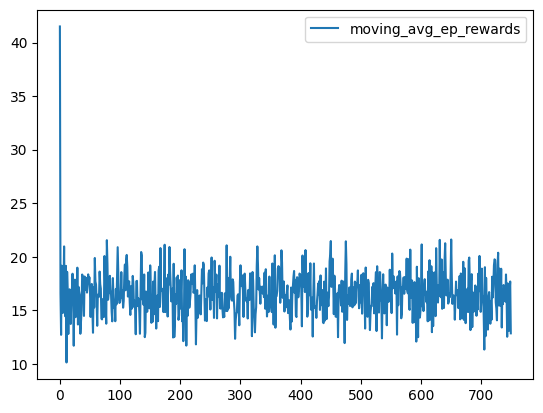

In [9]:
use_cuda = torch.cuda.is_available()
print(f"Using CUDA: {use_cuda}")
print()

save_dir = Path("checkpoints") / datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
save_dir.mkdir(parents=True)

Wordie = WordleAgent(state_dim=(2,6,5),action_dim=actions,save_dir=save_dir)
logger = MetricLogger(save_dir)
'''
    400k Episode is 8 hours on cpu
'''
episodes = 750000
for e in range(episodes):

    state = env.reset()

    # Play the game!
    while True:

        # Run agent on the state
        action = Wordie.act(state)

        # Agent performs action
        next_state, reward, done, dic = env.step(action)

        # Remember
        Wordie.cache(state, next_state, action, reward, done)

        # Learn
        q, loss = Wordie.learn()

        # Logging
        logger.log_step(reward, loss, q)

        # Update state
        state = next_state

        
        # Check if end of game
        if done:
            break

    logger.log_episode()
    
    if e % 1000 == 0:
        logger.record(episode=e, epsilon=Wordie.exploration_rate, step=Wordie.curr_step)
print(env.guessed_words)
print(env.WORD)

In [10]:
state = env.reset()

# Play the game!
while True:

    # Run agent on the state
    action = Wordie.act(state)

    # Agent performs action
    next_state, reward, done, dic = env.step(action)

    # Remember
    Wordie.cache(state, next_state, action, reward, done)

    # Learn
    q, loss = Wordie.learn()

    # Logging
    logger.log_step(reward, loss, q)

    # Update state
    state = next_state

    
    # Check if end of game
    if done:
        break

logger.log_episode()

if e % 20 == 0:
    logger.record(episode=e, epsilon=Wordie.exploration_rate, step=Wordie.curr_step)
env.render()

In [11]:
torch.save(Wordie.net.state_dict(), 'torch_weights')
pygame.display.quit()


In [12]:
model_weights = torch.load('/home/bobbymg/Documents/Deep Learning Projects/wordle_ai/torch_weights')

Episode 749999 - Step 4495185 - Epsilon 1.0 - Mean Reward 19.805 - Mean Length 5.98 - Solve Rate 0.0 - Mean Loss 8.797 - Mean Q Value 13.886 - Time Delta 63.053 - Time 2023-07-05T09:13:18


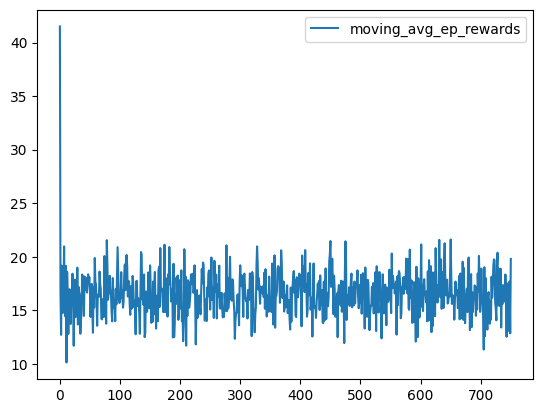

In [13]:
logger.record(episode=e, epsilon=Wordie.exploration_rate, step=Wordie.curr_step)

In [14]:
from torchsummary import summary

model = self.online = nn.Sequential(
            bias_layer,
            nn.ReLU(),
            nn.Conv3d(in_channels=32, out_channels=64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv3d(in_channels=64, out_channels=64, kernel_size=1, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )
summary(WordleNet((2,6,4), 2315), (2,6,5))


NameError: name 'bias_layer' is not defined